<h1 style="text-align: center;">H04U1C - Optimization of Mechatronic Systems</h1>

Consider the mass-spring-damper test setup depicted in the figure below, which you can consider as a model of quarter-car suspension.

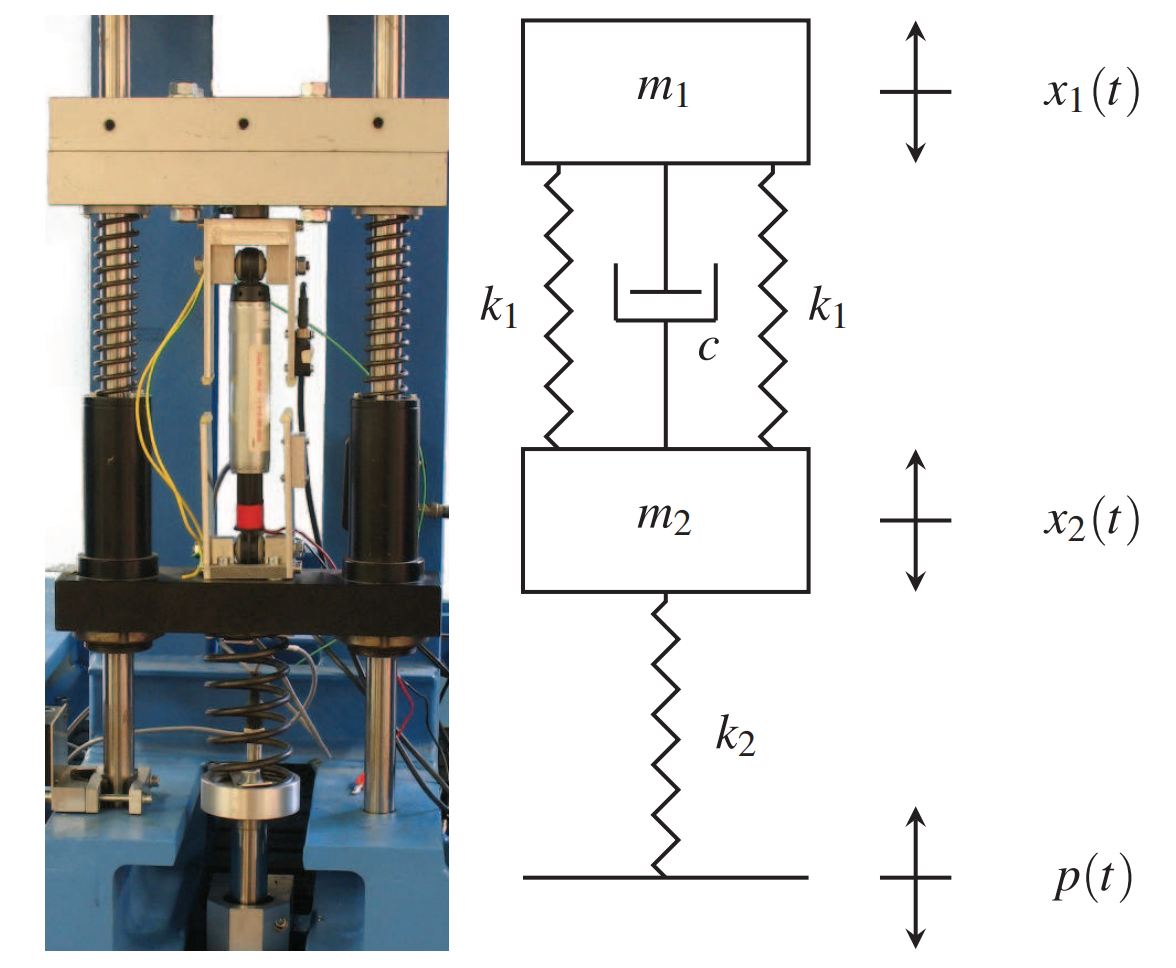

with

* $m_1 = 40 \text{ kg}$: mass of the quarter-car
* $2$*$k_1 = 9000 \frac{\text{ N}}{\text{ m}}$: stiffness of the suspension
* $c$: damping of the suspension
* $m_2 = 5 \text{ kg}$: mass of the tire
* $k_2 = 15000 \frac{\text{ N}}{\text{ m}}$: stiffness of the tire

Questions:

1. Write down the equations of motion of the quarter-car (in the time domain), in which you consider the road displacement $p(t)$ as a disturbance.

2. Simulate the behavior of the quarter-car, for a damping $c = 200 \frac{\text{ Ns}}{\text{ m}}$, starting from rest, subject to a step disturbance of $5 \text{ cm}$ in the road displacement. Plot the resulting evolution of the motion of the car as a function of time.

3. The quarter-car is equipped with a semiactive suspension, meaning that the damping $c$ is not a fixed value but can be controlled over time, hence, $c(t)$. In this assignment we make the simplified assumption that the damping can be changed instantaneously to any value between $c_{min}=0 \frac{\text{ Ns}}{\text{ m}}$ and $c_{max}=2000 \frac{\text{ Ns}}{\text{ m}}$, and we consider the following control law: 

    a. if $\dot{x}_1$ and $\dot{x}_1-\dot{x}_2$ have the same sign: $c = K \frac{\dot{x}_1}{\dot{x}_1-\dot{x}_2}$, but respecting to stay between $c_{min}$ and $c_{max}$.

    b. otherwise: $c = c_{min}$.

This is called the "skyhook control policy". Implement the equations of motion for the quarter-car with semiactive suspension. Simulate the system for a few values of $K$, for the same excitation as in question 2.

Hint: some useful CasADi functions: if_else, fmin, fmax, logsumexp. Check the CasADi documentation for more information.

4. Formulate two optimization problems to design 1) an optimal passive suspension, meaning a suspension with a fixed value of $c$, and 2) an optimal semi-active suspension with a skyhook control policy, meaning a suspension with a fixed value of $K$. Optimal means that the car body $x_1(t)$ deviates as little as possible from its steady-state value for a given road disturbance.

5. Solve both problems using CasADi-Opti with the Ipopt solver for a step disturbance of $1 \text{ cm}$, $5 \text{ cm}$, and $10 \text{ cm}$. Discuss the results.

6. Are your optimization problems convex? Motivate your answer.

7. What are computationally the most expensive parts when solving the system (look at the Ipopt output!)? Can you explain why this is the case? How would you speed up solving the problem?

# Solution

## Q1 - The equations of motion of the quarter-car are given by:

Car Body: $ \quad m_1 \ddot{x_1} = - k_1 (x_1 - x_2) - c (\dot{x_1} - \dot{x_2}) $

Tire: $ \quad m_2 \ddot{x_2} = - k_2 (x_2 - p(t)) + k_1 (x_1 - x_2) + c (\dot{x_1} - \dot{x_2}) $

## Q2 - Simulation of the quarter-car 

In [ ]:
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import *
from scipy.integrate import solve_ivp
from matplotlib.patches import Circle

# Define system parameters
m1 = 40  # kg
m2 = 5   # kg
k1 = 9000   # N/m
k2 = 15000  # N/m
c_fixed = 200  # Ns/m for Q2

# Skyhook control parameters
c_min = 0  # Ns/m
c_max = 2000  # Ns/m

# Define the step disturbance
def p(t):
    return 0.05 if t >= 0 else 0

# Define the control law for c(t)
def semiactive_suspension(x1_dot, x2_dot, K):
    if x1_dot * (x1_dot - x2_dot) > 0:
        c = K * x1_dot / (x1_dot - x2_dot)
        c = np.clip(c, c_min, c_max)
    else:
        c = c_min
    return c

# Define the equations of motion
def equations(t, y, K, skyhook=False):
    x1, x2, x1_dot, x2_dot = y
    if skyhook:
        c = semiactive_suspension(x1_dot, x2_dot, K)
    else:
        c = c_fixed
    x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - p(t)) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
    return [x1_dot, x2_dot, x1_ddot, x2_ddot]

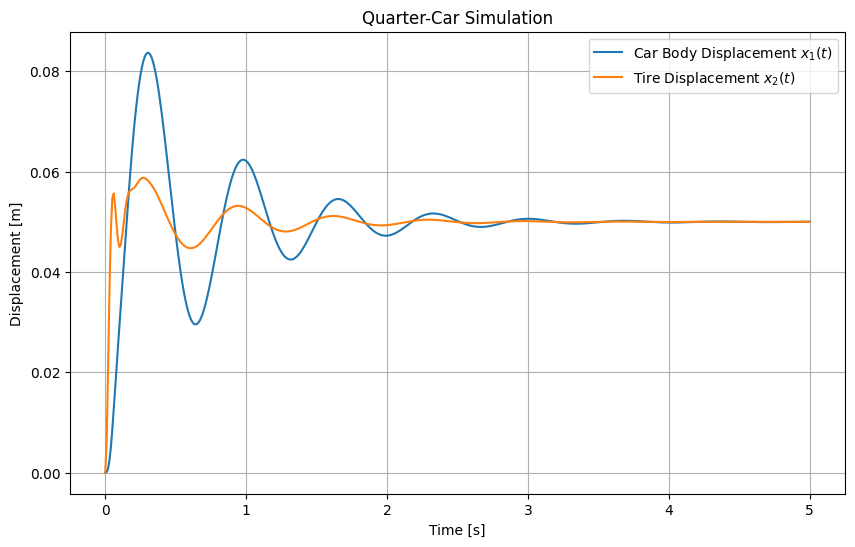

In [10]:
def Q2():
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the system of differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(0, False))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title('Quarter-Car Simulation')
    plt.legend()
    plt.grid()
    plt.show()

# Run Q2
Q2()

## Q3 - Implementation of the skyhook control policy

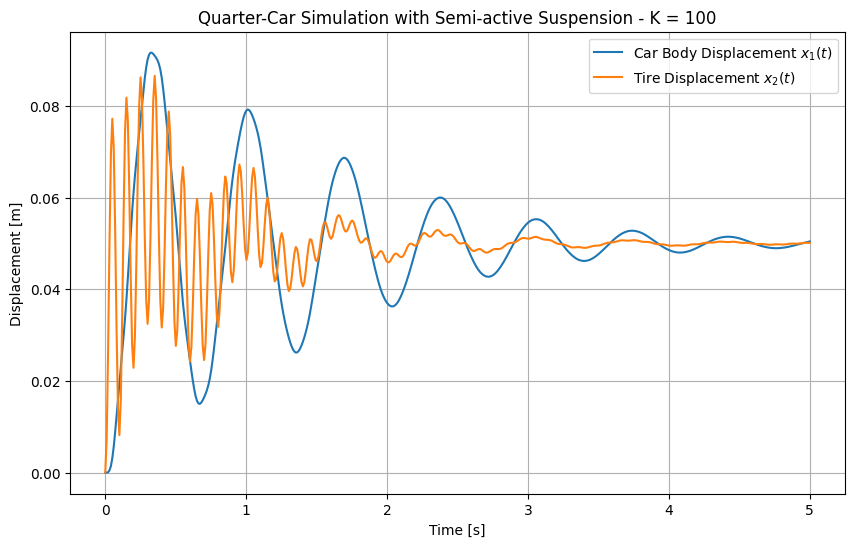

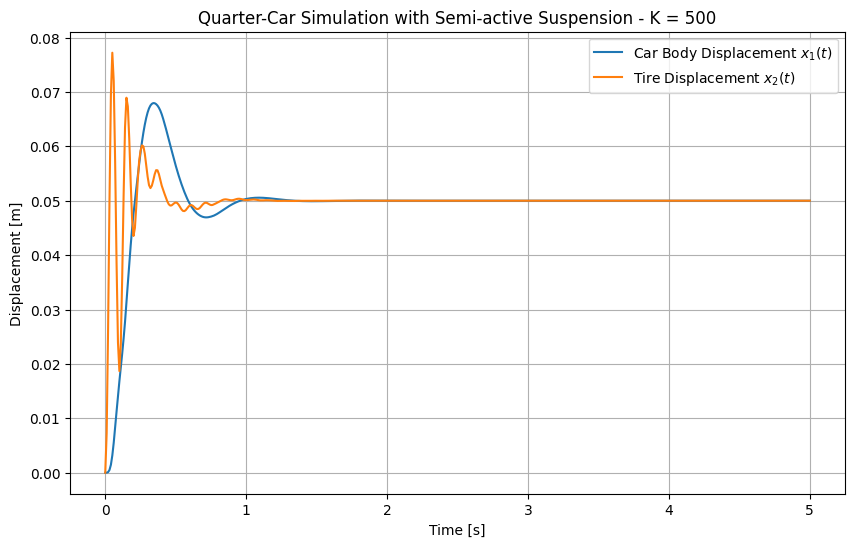

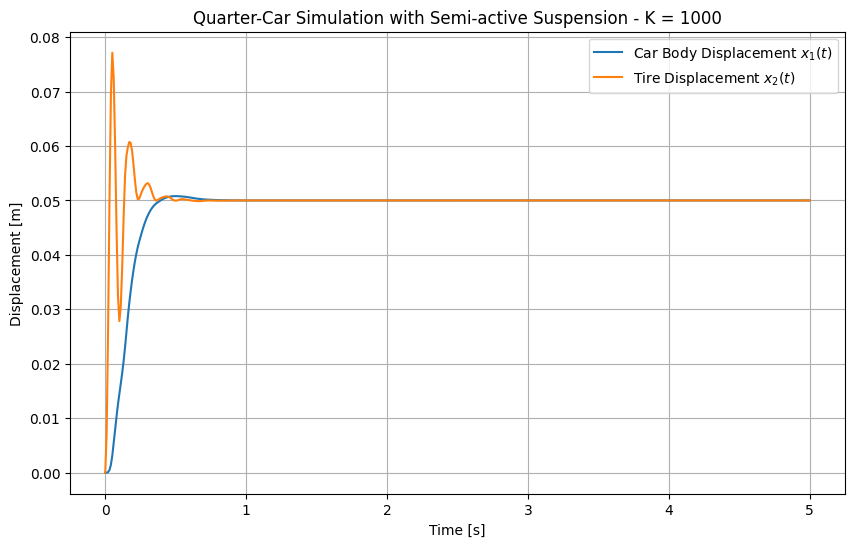

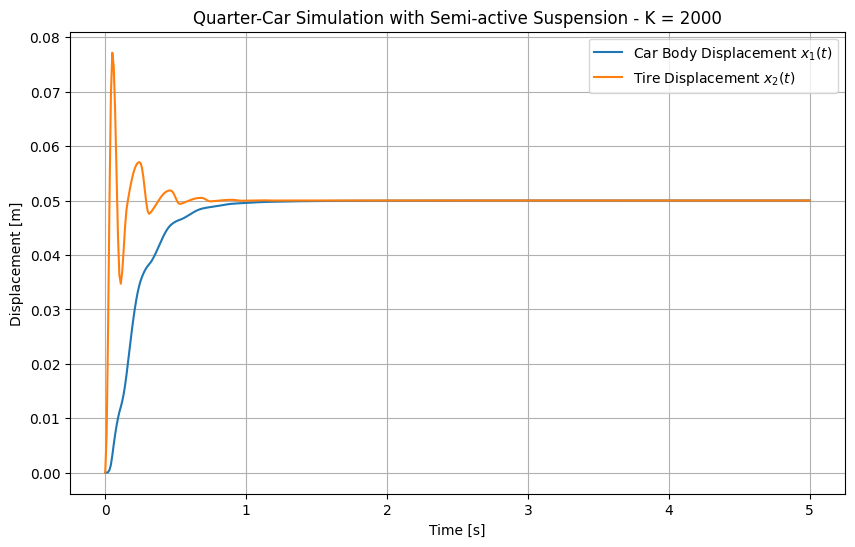

In [11]:
def Q3(K):
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the system of differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(K, True))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title('Quarter-Car Simulation with Semi-active Suspension - K = {}'.format(K))
    plt.legend()
    plt.grid()
    plt.show()

# Run Q3 with a different values of K
K = [100, 500, 1000, 2000]
for k in K:
    Q3(k)

## Q4 - Formulation of the optimization problems

Hint: some useful CasADi functions: if_else, fmin, fmax, logsumexp. Check the CasADi documentation for more information.

4. Formulate two optimization problems to design 1) an optimal passive suspension, meaning a suspension with a fixed value of $c$, and 2) an optimal semi-active suspension with a skyhook control policy, meaning a suspension with a fixed value of $K$. Optimal means that the car body $x_1(t)$ deviates as little as possible from its steady-state value for a given road disturbance.

In [12]:
# Optimal passive suspension (optimal value of c)

T = 5  # Total simulation time

# Define the optimization problem
opti = Opti()

# Decision variable and constraints (within reasonable bounds)
c = opti.variable()
opti.subject_to(c_min <= c <= c_max)

# Time variable
t = MX.sym('t')

# State variables
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x1_dot = MX.sym('x1_dot')
x2_dot = MX.sym('x2_dot')
states = vertcat(x1, x2, x1_dot, x2_dot)

# Equations of motion
x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
x2_ddot = (-k2 * (x2 - p(t)) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
rhs = vertcat(x1_dot, x2_dot, x1_ddot, x2_ddot)

# Define the ODE function
ode = {'x': states, 'p': t, 'ode': rhs}
F = integrator('F', 'cvodes', ode, {'tf': T/500})

# Initial conditions
x0 = np.array([0, 0, 0, 0])

# Simulate the system
x = x0
x1_traj = []
for i in range(500):
    t_val = i * T / 500
    res = F(x0=x, p=t_val)
    x = res['xf'].full().flatten()
    x1_traj.append(x[0])

# Objective function
objective = sum1(vertcat(*x1_traj)**2)
opti.minimize(objective)

# Solve the optimization problem
sol = opti.solve()

# Optimal damping coefficient
c_opt = sol.value(c)
print(f"Optimal damping coefficient: {c_opt}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, 500), x1_traj, label='Car Body Displacement $x_1(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Quarter-Car Simulation with Optimal Passive Suspension')
plt.legend()
plt.grid()
plt.show()

# -------------------------------------------------------------



# Optimal semi-active suspension (optimal value of K)



# -------------------------------------------------------------

RuntimeError: .../casadi/core/mx_node.cpp:203: Can only determine truth value of a numeric MX.